In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define some functions that will be used in the classes

In [3]:
class LitMetallicities():
    '''
    Class to 
    1.   read in Fe/H values from the literature 
    2.   initialize data set cross-referencing functionality
    '''
    
    def __init__(self):
    
        stem = "./rrlyrae_metallicity/src/high_res_feh/"

        # stand-in that consists of our program star names
        self.our_program_stars = pd.read_csv(stem + "our_program_stars_names_only.csv")
        
        # Fe/H from Layden+ 1994; this may serve as the common basis for RRabs
        self.layden_feh = pd.read_csv(stem + "layden_1994_abundances.dat")
        # RES: "rather low"
        
        # Fe/H Clementini+ 1995
        self.clementini_feh = pd.read_csv(stem + "clementini_1995_abundances.dat")

        # Fe/H Fernley+ 1996
        self.fernley_feh = pd.read_csv(stem + "fernley_1996_abundances.dat")
        # RES: 60,000, FeI & FeII, 5900-8100 A
        
        # log(eps) from Lambert+ 1996
        self.lambert_logeps = pd.read_csv(stem + "lambert_1996_abundances.dat")
        # RES: ~23,000, FeII + photometric models, 3600-9000 A
        
        # Fe/H from Wallerstein and Huang 2010, arXiv 1004.2017
        self.wallerstein_feh = pd.read_csv(stem + "wallerstein_huang_2010_abundances.dat")
        # RES: ~30,000, FeII
        
        # Fe/H from Chadid+ 2017 ApJ 835.2:187 (FeI and II lines)
        self.chadid_feh = pd.read_csv(stem + "chadid_2017_abundances.dat")
        # RES: 38000, FeI & FeII, 3400-9900 A

        # Fe/H from Liu+ 2013 Res Ast Astroph 13:1307
        self.liu_feh = pd.read_csv(stem + "liu_2013_abundances.dat")
        # RES: ~60,000, FeI (& FeII?), 5100-6400 A

        # Fe/H from Nemec+ 2013
        self.nemec_feh = pd.read_csv(stem + "nemec_2013_abundances.dat")
        # RES: ~65,000 or 36,000, FeI & FeII, 5150-5200 A

        # Fe/H from Fernley+ 1997
        self.fernley97_feh = pd.read_csv(stem + "fernley_1997_abundances.dat")
        # RES: 60,000, two FeII lines, 5900-8100 A

        # Fe/H from Solano+ 1997
        self.solano_feh = pd.read_csv(stem + "solano_1997_abundances.dat")
        # RES: 22,000 & 19,000, strong FeI lines, 4160-4390 & 4070-4490 A
        
        # Fe/H from Pancino+ 2015 MNRAS 447:2404
        self.pacino_feh = pd.read_csv(stem + "pacino_2015_abundances.dat") 
        # RES: >30,000, FeI (weighted average), 4000-8500 A

        # Fe/H from Sneden+ 2017
        self.sneden_feh = pd.read_csv(stem + "sneden_2017_abundances.dat")
        # RES: ~27,000 (at 5000 A), FeI & FeII, 3400-9000 A
        
        # convert Lambert's values, which are in terms of log(eps)
        # FeH = log(epsFe) - log(epsFe,sol)
        #     = log(epsFe) - log(NFe,sol/NH,sol)
        #     = log(epsFe) - 7.51 # value of 7.51 from Anstee+ 1997, MNRAS
        self.lambert_logeps['feh'] = np.subtract(self.lambert_logeps['log_eps_fe_spec'], 7.51) 
        
        # average the values in Chadid from FeI and FeII lines
        self.chadid_feh['feh'] = np.mean([self.chadid_feh['fehI'].values,self.chadid_feh['fehII'].values],axis=0)
        
        ## ## INCLUDE SINGLE DATA PT FROM KOLENBERG+ 2010? (SEE CHADID+ 2017, FIG. 7)
        
        # FYI: average Fe/H values in Liu+ 2013 which were taken at different phases
        # liu_feh.groupby(liu_feh['name'], axis=0, as_index=False).mean()
        
        # FYI: average Fe/H values in Sneden+ 1997 which were taken at different epochs
        # sneden_feh.groupby(sneden_feh['name'], axis=0, as_index=False).mean()
        
        # Fe/H from Kemper+ 1982; this might serve as the common basis for RRcs
        self.kemper_feh = pd.read_csv(stem + "kemper_1982_abundances.dat")

        # Fe/H from Govea+ 2014
        ## ## note: Govea+ has abundances for each phase value, and this includes NLTE phases; how to get single Fe/H?
        self.govea_feh = pd.read_csv(stem + "govea_2014_abundances.dat")
        

        #####################
        
        # initialize arrays: essential info
        empir_spec_name_array = []
        star_name_array = []
        H_data_array = []
        K_data_array = []
        err_H_data_array = [] 
        err_K_data_array = []

        # initialize arrays: other info
        Hbet_data_array = []
        err_Hbet_data_array = []
        Hgam_data_array = []
        err_Hgam_data_array = []
        rHgam_data_array = [] # rescaled Hgamma
        err_rHgam_data_array = []
        Hdel_data_array = []
        err_Hdel_data_array = []
        Heps_data_array = []
        err_Heps_data_array = []
        
    def __call__(self):
        
        # make a list of all unique EMPIRICAL spectrum names
        uniqueSpecNames = line_data.drop_duplicates(subset='empir_spec_name')['empir_spec_name']

    def matchmaker(self, input_table, basis_table, highres_dataset_name):
        '''
        Find what stars are common to two input tables, and return array of FeHs from the first table

        INPUTS:
        input_table: table I'm interested in checking for overlapping stars 
            (pandas dataframe with col ['name']: star name; col ['feh']: Fe/H)
        basis_table: table with the names for which I am looking for repeats in the other table
            (pandas dataframe with col ['name']: star name; col ['feh']: Fe/H)
        highres_dataset_name: string indicating the name of the highres dataset

        OUTPUTS:
        pandas dataframe with
        1. overlapping star names
        2. FeHs from the input_table
        3. FeHs from the basis_table
        4. residuals in FeH: FeH_input - FeH_basis
        5. string indicating the high-res dataset being matched
        '''

        self.input_table = input_table
        self.basis_table = basis_table
            
        input_FeH = [] # Fe/H of high-res study
        basis_FeH = [] # Fe/H of basis (ex. Layden 1994)
        star_name_array = [] # name of star

        for row in range(0,len(input_table)): # scan over each row in input table
            if (basis_table['name'] == input_table['name'][row]).any():
                input_FeH = np.append(input_FeH,input_table['feh'][row])
                basis_FeH = np.append(basis_FeH,basis_table.loc[basis_table['name'] == input_table['name'][row]]['feh'])
                star_name_array = np.append(star_name_array,input_table['name'][row])

        d = dict()
        d['name_star'] = star_name_array
        d['FeH_highres'] = input_FeH
        d['FeH_basis'] = basis_FeH
        d['name_highres_dataset'] = np.repeat(highres_dataset_name, len(star_name_array))
        d['name_basis_dataset'] = np.repeat(highres_dataset_name, len(star_name_array))
        
        df = pd.DataFrame(data=d)
        
        return df
    
    
    def match_highres_w_basis(self, star_type):
        '''
        Find what stars overlap with basis data set, and return star name, data set names, 
            FeH values, residuals

        The functionality of LitMetallicities is inherited
        N.b. There are no offsets applied yet (as are applied in Chadid+ 2017 plots)

        INPUTS:
        input_table: table of high-res-derived Fe/H values, which I want to cross-ref with 
            a basis (like Layden 94 or Kemper 82)
        basis_table: the table which serves as the basis set
        plot_name: file name for saving a plot of the results

        OUTPUTS:
        df: concatenated frames containing 
            ['name_star']: star_name_array
            ['FeH_highres']: Fe/H from high-res study
            ['FeH_basis']: Fe/H from basis set
            ['name_highres_dataset']: string indicating the high-res dataset
            ['name_basis_dataset']: string indicating the basis set
        '''

        # define the basis data set (like Layden 1994 for RRabs, or Kemper+ 1982 for RRcs)
        if star_type == "RRab":
            type_string = "ab"
            basis_set = self.layden_feh
            basis_string = "Layden RRab basis set" # string for plots
        elif star_type == "RRc":
            type_string = "c"
            basis_set = self.kemper_feh
            basis_string = "Kemper RRc basis set"
        else:
            sys.exit("Error! No RR Lyrae subtype chosen.")


        ## match ALL available high-res studies with the basis set

        pd_Lambert_1996 = self.matchmaker(self.lambert_logeps, 
                                          basis_set, 
                                          highres_dataset_name="lambert_1996") # Lambert+ 1996 (logeps has already been converted to Fe/H)
        pd_Nemec_2013 = self.matchmaker(self.nemec_feh, 
                                        basis_set,
                                        highres_dataset_name="nemec_2013") # Nemec+ 2013
        pd_Chadid_2017 = self.matchmaker(self.chadid_feh, 
                                         basis_set,
                                         highres_dataset_name="chadid_2017") # Chadid+ 2017
        pd_Fernley_1997 = self.matchmaker(self.fernley97_feh, 
                                          basis_set,
                                          highres_dataset_name="fernley_1997") # Fernley+ 1997
        pd_Solano_1997 = self.matchmaker(self.solano_feh, 
                                         basis_set,
                                         highres_dataset_name="solano_1997") # Solano+ 1997
        pd_Wallerstein_2010 = self.matchmaker(self.wallerstein_feh, 
                                              basis_set,
                                              highres_dataset_name="wallerstein_2010") # Wallerstein 2010

        # for Liu+ 2013, we need to group multiple Fe/H values by star name
        # (the grouping is done here rather than further up because a bug causes the grouped column to disappear)
        self.liu_feh_grouped = self.liu_feh.groupby(self.liu_feh["name"], axis=0, as_index=False).mean()
        pd_Liu_2013 = self.matchmaker(self.liu_feh_grouped, 
                                      basis_set,
                                      highres_dataset_name="liu_2013") # Liu+ 2013

        # for Govea+ 2014, we need to group multiple Fe/H_I and Fe/H_II values by star name
        # (the grouping is done here rather than further upstream because otherwise a bug causes 
        # the grouped column to disappear)
        self.govea_feh_grouped = self.govea_feh.groupby(self.govea_feh["name"], axis=0, as_index=False).mean()
        # now, average the Fe/H_I and Fe/H_II values to get single Fe/H values
        self.govea_feh_grouped["feh"] = self.govea_feh_grouped[["feIh","feIIh"]].mean(axis=1)
        pd_Govea_2014 = self.matchmaker(self.govea_feh_grouped, 
                                        basis_set,
                                        highres_dataset_name="govea_2014") # Govea+ 2014

        # merge dataframes
        pd_collected = [pd_Lambert_1996, pd_Nemec_2013, pd_Liu_2013, pd_Chadid_2017,
                        pd_Fernley_1997, pd_Solano_1997, pd_Wallerstein_2010, pd_Govea_2014]
        df = pd.concat(pd_collected).reset_index()

        return df

In [4]:
def return_offsets(data_postmatch, chadid_offset=True):
    '''
    Fit linear regression to input high-res Fe/H and the basis set,
    and find offset for each dataset to match some constant
    
    INPUTS:
    data_postmatch: output from match_w_highres_basis(), containing
        Fe/H data from high-res studies and basis set
        
    OUTPUTS:
    df: dataframe containing
    ['name_highres_dataset']: name indicating high-res study
    ['offset_highres_dataset_residuals']: offset for the entire high-res 
        dataset, which needs to be applied to the vector (FeH_highres-FeH_basis)
    '''
    
    # initialize dataframe
    col_names =  ["name_highres", "offset_highres_residuals"]
    df_offsets  = pd.DataFrame(columns = col_names)
    
    # loop over each high-res dataset
    highres_names = data_postmatch["name_highres_dataset"].unique() # names of high-res datasets
    index_counter = 0 # initialize this for appending dataframes
    for dataset_num in range(0,len(highres_names)):
        
        this_dataset_name = highres_names[dataset_num] # name of this dataset
        this_dataset = data_postmatch[data_postmatch["name_highres_dataset"].str.match(this_dataset_name)]
    
        # need at least 3 data points
        if (len(this_dataset["FeH_highres"]) > 2): 
    
            # find linear regression of residuals
            coeff = np.polyfit(this_dataset["FeH_basis"],
                               np.subtract(this_dataset["FeH_highres"],
                                           this_dataset["FeH_basis"]),1)
            limits = [-3.0,0.5] # Fe/H limits to display
            line = np.multiply(coeff[0],limits)+coeff[1] # points to plot linear regression

            # find offset between residuals and Chadid+ 2017 at Fe/H=-1.25 (see their Fig. 6)
            if chadid_offset: 
                chadid_y_125 = -0.10583621694962 # from Chadid line at Fe/H=-1.25
                FeH_resid_to_peg = chadid_y_125 # peg the FeH residuals to this y- point
                FeH_basis_loc = -1.25 # corresponding x- value (Fe/H in the basis dataset)
            else: 
                FeH_resid_to_peg = 0. # peg the data at this y- point
                FeH_basis_loc = 0. # location in the basis dataset 
                print("Offset corresponds to (0,0)!")

            # y-value of the unshifted linear regression line at Fe/H=-1.25
            this_y_125 = np.multiply(coeff[0],FeH_basis_loc)+coeff[1] 

            # offset to shift the linear regression line of the residuals to FeH_resid_to_peg
            net_offset = chadid_y_125 - this_y_125

            # line_offset = np.add(line,net_offset)

            print('-----------------')
            print('Calculating offsets for dataset '+this_dataset_name)
            print('Y_offset to add to residuals in order to overlap with Chadid+ 2017 at Fe/H=-1.25:')
            print(net_offset)
            print('Number of overlapping stars:')
            print(len(this_dataset["FeH_basis"]))

            # append name of dataset and its offset to array
            dict_this = {"name_highres":[this_dataset_name],
                         "offset_highres_residuals":[net_offset]}
            #print(pd.DataFrame(dict_this, index=[dataset_num]))
            
            # append info from this dataset
            print(dict_this)
            print(list(dict_this.items()))
            print(pd.DataFrame(dict_this))
            df_offsets = df_offsets.append(pd.DataFrame(dict_this)) 
            index_counter += 1 # increase the counter
            
        elif (len(this_dataset["FeH_highres"]) <= 2): 
            
            '''
            # put in NaN offset
            dict_this = {"name_highres": this_dataset_name,
                         "offset_highres_residuals": np.nan}
            #print(pd.DataFrame(dict_this, index=[dataset_num]))
            
            # append info from this dataset
            df_offsets = df_offsets.append(pd.DataFrame(dict_this)) 
            
            index_counter += 1 # increase the counter
            '''
            pass
 
    return df_offsets

In [5]:
def make_basis_via_offsets(df_to_offset,df_offsets,plot_string):
    '''
    Apply offsets (which may be from RRabs, RRcs, combo, etc.) to data to make a basis

    INPUTS:
    df_to_offset: dataframe containing Fe/H values which we want to find residuals for, offset, and map
        ['name_star']: star name
        ['FeH_highres']: Fe/H from high-res study
        ['FeH_basis']: Fe/H from basis set
        ['name_highres_dataset']: string indicating the high-res dataset
        ['name_basis_dataset']: string indicating the basis set
          
    df_offsets: dataframe containing the offset values and high-res dataset names
        ['name_highres_dataset']: name indicating high-res study
        ['offset_highres_dataset_residuals']: offset value to add to Fe/H values
        
    OUTPUTS:
    d: dictionary with
        "m_merged_highres": slope of high_res_FeH vs. FeH_basis
        "b_merged_highres": y-intercept of " " " "
        "m_merged_shifted_resid": slope of high_res_FeH residuals (i.e., high_res_FeH minus FeH_basis) vs. FeH_basis
        "b_merged_shifted_resid": y-intercept of " " " "
    '''

    dict_merged_this_basis = {} # initialize dictionaries
    dict_not_merged_this_basis = {}
    highres_names = df_to_offset["name_highres_dataset"].unique() # names of high-res datasets (which will also be the keys to dict_merged_this_basis)
    
    
    # for each high-res dataset name, apply the offsets to Fe/H residuals
    for this_dataset_name in highres_names:    
        
        this_dataset = df_to_offset[df_to_offset["name_highres_dataset"].str.match(this_dataset_name)]
        
        #print('this_resid_offset')
        #print(df_offsets['offset_highres_residuals'].loc[df_offsets['name_highres'] == this_dataset_name].values)
        
        # retrieve the required offset
        this_resid_offset = df_offsets['offset_highres_residuals'].loc[df_offsets['name_highres'] == this_dataset_name].values
        
        if this_resid_offset: # if there is an offset that could be found for this dataset
            this_dataset["residuals_no_shift"] = np.subtract(this_dataset["FeH_highres"],this_dataset["FeH_basis"])
            this_dataset["residuals_shifted"] = np.add(this_dataset["residuals_no_shift"],this_resid_offset)
    
            # add dataframe to dictionary; 
            # each key corresponds to a high-res dataset, and each value is a dataframe (this is good for plotting)
            dict_not_merged_this_basis[this_dataset_name] = this_dataset
        
        else:
            continue
        
    # merge ["residuals_shifted"] and ["FeH_highres"] across all 
    # dataframes in the dictionary (this is good for finding net Fe/H mapping)
    vals_of_interest = dict_not_merged_this_basis.copy()
    pd_merged = pd.concat(vals_of_interest.values(), ignore_index=True)
    
    # A value is trying to be set on a copy of a slice from a DataFrame.
    # Try using .loc[row_indexer,col_indexer] = value instead
    
    # find best-fit line to Fe/H plot of high_res vs. basis 
    # (note that user may have used a flag to make Fe/H values be offset)
    limits = [-3.0,0.5] # Fe/H limits to display
    
    m_merged_highres, b_merged_highres = np.polyfit(pd_merged["FeH_basis"], pd_merged["FeH_highres"], 1)
    line_highres = np.multiply(m_merged_highres,limits)+b_merged_highres # make best-fit line for high-res Fe/H
    
    m_merged_shifted_resid, b_merged_shifted_resid = np.polyfit(pd_merged["FeH_basis"], pd_merged["residuals_shifted"], 1)
    line_shifted_resid = np.multiply(m_merged_shifted_resid,limits)+b_merged_shifted_resid # make best-fit line for residuals
    
    # save a plot (high_res vs. basis on top; residuals vs. basis on bottom)
    plt.clf()
    limits = [-3.0,0.5]
    fig, axs = plt.subplots(2, 1, figsize=(10,10), sharex=True)
    
    axs[0].plot([limits[0],limits[1]],[limits[0],limits[1]], linestyle='--') # make 1-to-1 line
    axs[0].plot([limits[0],limits[1]],np.add(np.multiply(m_merged_highres,[limits[0],limits[1]]),b_merged_highres), linestyle='--') # best-fit line
    axs[0].scatter(pd_merged["FeH_basis"], pd_merged["FeH_highres"]) # input vs. basis
    # for keeping data points separated by datasets, plot with a list comprehension
    [axs[0].scatter(dict_not_merged_this_basis[key]["FeH_basis"], 
                    dict_not_merged_this_basis[key]["FeH_highres"], 
                    label=key) for key in dict_not_merged_this_basis] 
    # add star names
    for point in range(0,len(pd_merged["FeH_basis"])): 
        axs[0].annotate(
            pd_merged["name_star"][point],
            xy=(pd_merged["FeH_basis"][point], 
                pd_merged["FeH_highres"][point]), 
            xytext=(pd_merged["FeH_basis"][point]+0.1, 
                    pd_merged["FeH_highres"][point]+0.06),
            textcoords='data', ha='right', va='bottom',
            fontsize=10,
            arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0'))
    
    axs[0].set_xlim(limits[0], limits[1])
    axs[0].set_ylabel("Fe/H, high-res; no offsets applied")
    axs[0].set_title("m = "+str(m_merged_highres)+", b = "+str(b_merged_highres)+"; (blue line: 1-to-1; orange line: best fit)")
    axs[0].legend() # indicates high-res dataset names
    
    axs[1].axhline(y=0, linestyle='--') # dashed line at y=0
    axs[1].scatter(df_to_offset['FeH_basis'], np.subtract(df_to_offset['FeH_highres'],df_to_offset['FeH_basis'])) # input vs. basis
    axs[1].scatter(pd_merged["FeH_basis"], pd_merged["residuals_shifted"], alpha=0.5) # input vs. basis
    # for keeping data points separated by datasets, plot with a list comprehension
    [axs[1].scatter(dict_not_merged_this_basis[key]["FeH_basis"], 
                    dict_not_merged_this_basis[key]["residuals_shifted"], 
                    label=key) for key in dict_not_merged_this_basis] 
    # add star names
    for point in range(0,len(pd_merged["FeH_basis"])): 
        axs[1].annotate(
            pd_merged["name_star"][point],
            xy=(pd_merged["FeH_basis"][point], 
                pd_merged["residuals_shifted"][point]), 
            xytext=(pd_merged["FeH_basis"][point]+0.1, 
                    pd_merged["residuals_shifted"][point]+0.06),
            textcoords='data', ha='right', va='bottom',
            fontsize=10,
            arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0'))
    axs[1].set_xlabel("Fe/H, Basis")
    axs[1].set_ylabel('Fe/H Residuals: high-res minus basis set')
    axs[1].set_title("m = "+str(m_merged_shifted_resid)+", b = "+str(b_merged_shifted_resid)+"; (blue line: zero)")
    axs[1].set_ylim([-1.5,1.5])
    axs[1].legend() # indicates high-res dataset names
    
    #fig.suptitle("Finding remapping relation between\nhigh-res studies and basis dataset\n("+type_string+" subtype)")
    #fig.tight_layout()
    plt.savefig(plot_string, overwrite=True)
    plt.clf()
    
    print("Scatter in residuals before offsets:")
    print(np.std(np.subtract(df_to_offset['FeH_highres'],df_to_offset['FeH_basis'])))
    print("Number of data points:")
    print(len(np.subtract(df_to_offset['FeH_highres'],df_to_offset['FeH_basis'])))
    print("-----")
    print("Scatter in residuals after offset shifts:")
    print(np.std(pd_merged["residuals_shifted"]))
    print(len(pd_merged["residuals_shifted"]))
    
    #d['coeff_merged_highres'] = [m_merged_highres, b_merged_highres] # best-fit line coeffs for high-res vs. basis 
    #d['coeff_merged_resid'] = [m_merged_resid, b_merged_resid] # best-fit line coeffs for (residuals: high-res minus basis) vs. basis 
    
    d = {
        "m_merged_highres": m_merged_highres,
        "b_merged_highres": b_merged_highres,
        "m_merged_shifted_resid": m_merged_shifted_resid,
        "b_merged_shifted_resid": b_merged_shifted_resid
    }
    
    return d

In [113]:
class MetalBasisTypeSpecific(LitMetallicities):
    '''
    Class to make metallicity bases specific to subtypes: RRab, RRc
    '''

    def __init__(self, 
                 plot_name):
        '''
        INPUTS:
        plot_name: string for the plot file name
        '''
        
        super().__init__()
        self.__plot_name = plot_name
        #self.__star_type = star_type
        #self.__offset = offset
        
        
    def calc_FeH_program_stars(self):
        '''
        Calculate metallicities for the program stars which form the basis of the
        metallicity calibration, by using the remapping relationships

        INPUTS:
        basis_set: basis set used for either RRab (such as Layden 1994) or RRc (such as Kemper+ 1982)
        '''
        
        # match the RRab, RRcs stars with their basis sets
        rrab_matches = self.match_highres_w_basis("RRab")
        rrc_matches = self.match_highres_w_basis("RRc")
    
        # find necessary offsets to FeH_highres-FeH_basis
        print("======= STEP 1a: CALCULATE RRAB OFFSETS ========")
        rrab_offsets = return_offsets(data_postmatch = rrab_matches)
        print("======= STEP 1a: PRINT RRAB OFFSETS ========")
        print(rrab_offsets)
        print("======= STEP 2a: CALCULATE RRC OFFSETS ========")
        rrc_offsets = return_offsets(data_postmatch = rrc_matches)
        print("======= STEP 2b: PRINT RRC OFFSETS ========")
        print(rrc_offsets)
        
        # make the Fe/H bases based on the found offsets
        print("======= STEP 3: MAKE RRAB BASIS W RRAB OFFSETS ========")
        rrab_basis_w_rrab_offsets = make_basis_via_offsets(df_to_offset = rrab_matches,
                                                           df_offsets = rrab_offsets,
                                                           plot_string = "rrab_w_rrab_offsets.png")
        print(rrab_basis_w_rrab_offsets)
        print("======= STEP 4: MAKE RRAB BASIS W RRC OFFSETS ========")
        rrab_basis_w_rrc_offsets = make_basis_via_offsets(df_to_offset = rrab_matches,
                                                          df_offsets = rrc_offsets,
                                                          plot_string="rrab_w_rrc_offsets.png")
        print("======= STEP 5: MAKE RRC BASIS W RRC OFFSETS ========")
        rrc_basis_w_rrc_offsets = make_basis_via_offsets(df_to_offset = rrc_matches,
                                                         df_offsets = rrc_offsets,
                                                         plot_string="rrc_w_rrc_offsets.png")
        print("======= STEP 6: MAKE RRC BASIS W RRAB OFFSETS ========")
        rrc_basis_w_rrab_offsets = make_basis_via_offsets(df_to_offset = rrc_matches,
                                                          df_offsets = rrab_offsets,
                                                          plot_string="rrc_w_rrab_offsets.png")
        
        # use the bases to put Fe/H values on a common scale 
        # i.e., to have ONE high-res-spectroscopically determined 
        # Fe/H value for making the metallicity calibration
        
        # mapping is
        # [Fe/H]_highres = m*[Fe/H]_basis_set + b   
        
        ## TEST
        test_feh_highres = np.add(rrab_basis_w_rrab_offsets["m_merged_highres"]*rrab_matches["FeH_basis"],
                                  rrab_basis_w_rrab_offsets["b_merged_highres"])
        
        
        # test for finding error bars
        
        # method 1: for each of star name in a matching, 
        #           find each high-res FeH value for that star
        #           - apply offset for that high-res study
        #           find std of those datapoints
        
        error_bars_all = pd.DataFrame(columns=["name_star","error_from_std_of_offset_fehs"])
        
        # loop over each star
        for name in rrab_matches["name_star"].unique():
            
            error_bars_this_star = pd.DataFrame()
            
            list_of_offset_fehs = np.nan*np.ones(100) # initialize array 
            counter = 0 # initialize counter
            
            # if there are at least 3 appearances of the star in high-res studies
            if (len(rrab_matches["name_star"].where(rrab_matches["name_star"] == name).dropna()) >= 3):
                print("-----")
                this_star_info = rrab_matches.where(rrab_matches["name_star"] == name).dropna().reset_index(drop=True)
                print(this_star_info.dropna())
                
                # for each high-res study, apply the offset to the FeH for that star
                
                for high_res_study in this_star_info["name_highres_dataset"]:
                    print(high_res_study)
                    # retrieve FeH and required offset from that dataset
                    feh_from_that_dataset = this_star_info["FeH_highres"].where(this_star_info["name_highres_dataset"] == high_res_study)
                    print(rrab_offsets.keys())
                    offset_from_that_dataset = rrab_offsets["offset_highres_residuals"].where(rrab_offsets["name_highres"] == high_res_study)
                    print(offset_from_that_dataset.dropna())                                                                         
                    # apply the offset to FeH value from that dataset for that star
                    feh_w_offset = np.subtract(feh_from_that_dataset.dropna(),offset_from_that_dataset.dropna()) ## ## OR IS IT ADD?
                    print('feh_from_that_dataset:')
                    print(feh_from_that_dataset)
                    print('feh_w_offset:')
                    print(feh_w_offset)
                    print(np.shape(list_of_offset_fehs))
                    print(np.shape(feh_w_offset))
                    list_of_offset_fehs[counter] = feh_w_offset
                    counter += 1 # advance counter
                    
                print('list of offset fehs')
                print(list_of_offset_fehs)
                print('std therof')
                print(np.nanstd(list_of_offset_fehs))
                
                # add the info to the dataframe
                error_bars_this_star["name_star"] = [str(name)]
                error_bars_this_star["error_from_std_of_offset_fehs"] = [np.nanstd(list_of_offset_fehs)]
                
                # concatenate the data
                print('name')
                print(name)
                print('error_bars_this_star')
                print(error_bars_this_star)
                error_bars_all = pd.concat([error_bars_all,error_bars_this_star])
                
        print('fafs')
        print(error_bars_all)
                #test_std = np.nanstd(rrab_matches["FeH_highres"].where(rrab_matches["name_star"] == name))
                #print(name + " " + str(test_std))
            
        
        #rrab_matches
        #['name_star']: star_name_array
        #    ['FeH_highres']: Fe/H from high-res study
        #    ['FeH_basis']: Fe/H from basis set
        #    ['name_highres_dataset']: string indicating the high-res dataset
        #    ['name_basis_dataset']
        
        # save a plot of calibration program stars Fe/H
        # post-mapped Fe/H vs. basis set Fe/H
        
        limits = [-3.0,0.5]

        # abs w ab offsets
        plt.clf()
        fig, axs = plt.subplots(1, 1, figsize=(20,15))
        axs.plot([limits[0],limits[1]],[limits[0],limits[1]], linestyle='--') # make 1-to-1 line
        axs.scatter(rrab_matches["FeH_basis"], test_feh_highres) # input vs. basis
        axs.set_xlim(limits[0], limits[1])
        axs.set_ylabel("Fe/H, high-res")
        axs.set_xlabel("Fe/H, basis")
        
        # plot the Fe/H values from all the high-res basis sets
        axs.scatter(rrab_matches["FeH_basis"],rrab_matches["FeH_highres"], alpha=0.5)
        
        # add star names and error bars
        for point in range(0,len(rrab_matches["name_star"])): 
            # if there is an error bar, overlay it
            yerr_this_star = error_bars_all["error_from_std_of_offset_fehs"].where(error_bars_all["name_star"] == rrab_matches["name_star"][point]).dropna()
            if len(yerr_this_star != 0):
                axs.annotate(rrab_matches["name_star"][point],
                             xy=(rrab_matches["FeH_basis"][point], 
                                 test_feh_highres[point]), 
                             xytext=(rrab_matches["FeH_basis"][point]+0.1, 
                                     test_feh_highres[point]+0.06),
                             textcoords='data', ha='right', va='bottom',
                             fontsize=10,
                             arrowprops=dict(arrowstyle = '-', connectionstyle='arc3,rad=0'))
                axs.errorbar(rrab_matches["FeH_basis"][point],
                             test_feh_highres[point],
                             yerr = yerr_this_star,
                             capsize=2,
                             ecolor="k")
        
        #plt.show()
        plt.savefig('junk.pdf', overwrite=True)
        #axs.set_title("m = "+str(m_merged_highres)+", b = "+str(b_merged_highres))

        '''
        fig.suptitle('Calculated Fe/H of calibration program stars\n('+type_string+' subtype)')
        #fig.tight_layout()
        plt.savefig('calculated_FeH_'+self.__plot_name, overwrite=True)
        plt.clf()

        # write out
        convert_to_df = pd.DataFrame.from_dict(dict_our_program_stars['name']) # initialize
        convert_to_df.columns = ['name'] # rename the column
        convert_to_df['mapped_feh'] = pd.DataFrame.from_dict(dict_our_program_stars['mapped_feh']) # add the remapped Fe/H
        no_return = convert_to_df.to_csv(write_loc + "mapped_feh.csv") # write out ## ## note 2 things: 1., this should be appeneded to our .csv with EWs; 2. there is no phase info here yet
        '''
        
        return rrab_basis_w_rrab_offsets, rrab_basis_w_rrc_offsets, rrc_basis_w_rrc_offsets, rrc_basis_w_rrab_offsets

======= STEP 1a: CALCULATE RRAB OFFSETS ========
-----------------
Calculating offsets for dataset lambert_1996
Y_offset to add to residuals in order to overlap with Chadid+ 2017 at Fe/H=-1.25:
-0.09526329009940923
Number of overlapping stars:
14
{'offset_highres_residuals': [-0.09526329009940923], 'name_highres': ['lambert_1996']}
[('offset_highres_residuals', [-0.09526329009940923]), ('name_highres', ['lambert_1996'])]
   name_highres  offset_highres_residuals
0  lambert_1996                 -0.095263
-----------------
Calculating offsets for dataset nemec_2013
Y_offset to add to residuals in order to overlap with Chadid+ 2017 at Fe/H=-1.25:
-0.33561597402175003
Number of overlapping stars:
10
{'offset_highres_residuals': [-0.33561597402175003], 'name_highres': ['nemec_2013']}
[('offset_highres_residuals', [-0.33561597402175003]), ('name_highres', ['nemec_2013'])]
  name_highres  offset_highres_residuals
0   nemec_2013                 -0.335616
-----------------
Calculating offsets f

/Users/nyumbani/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nyumbani/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Scatter in residuals before offsets:
0.2877068266180164
Number of data points:
135
-----
Scatter in residuals after offset shifts:
0.25738985970736583
135
{'b_merged_highres': 0.0921067587229675, 'm_merged_shifted_resid': 0.004438849729737716, 'b_merged_shifted_resid': -0.10358510250310123, 'm_merged_highres': 0.9942584197778669}
======= STEP 4: MAKE RRAB BASIS W RRC OFFSETS ========


/Users/nyumbani/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:41: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


Scatter in residuals before offsets:
0.2877068266180164
Number of data points:
135
-----
Scatter in residuals after offset shifts:
0.3356359591124351
66
======= STEP 5: MAKE RRC BASIS W RRC OFFSETS ========
Scatter in residuals before offsets:
0.27250501081752726
Number of data points:
23
-----
Scatter in residuals after offset shifts:
0.21578327348657825
19
======= STEP 6: MAKE RRC BASIS W RRAB OFFSETS ========
Scatter in residuals before offsets:
0.27250501081752726
Number of data points:
23
-----
Scatter in residuals after offset shifts:
0.2391191897986799
22
-----
   index  FeH_basis  FeH_highres name_basis_dataset name_highres_dataset  \
0    0.0      -0.38        -0.33       lambert_1996         lambert_1996   
1    9.0      -0.38         0.20         nemec_2013           nemec_2013   
2   12.0      -0.38        -0.07           liu_2013             liu_2013   
3    0.0      -0.38        -0.24       fernley_1997         fernley_1997   
4    0.0      -0.38        -0.36        solan

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

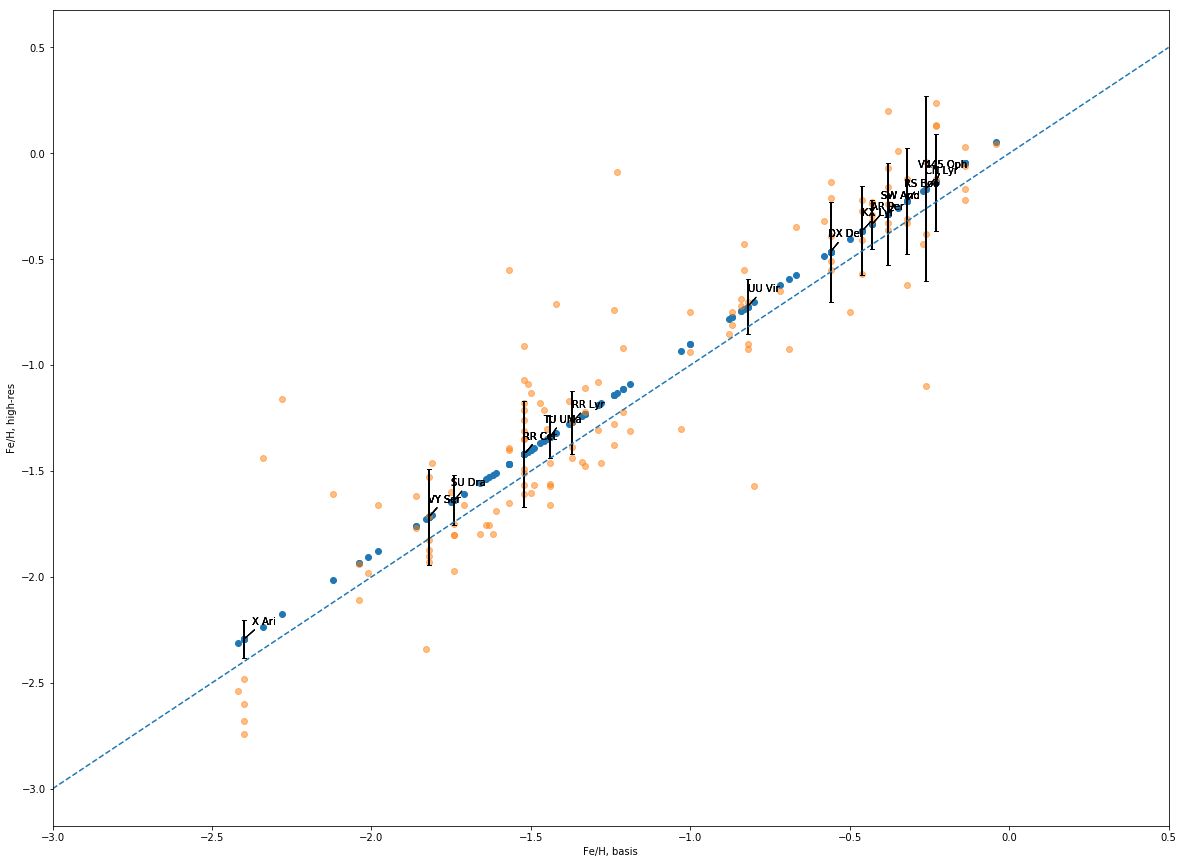

In [114]:
test = MetalBasisTypeSpecific(plot_name="name_here").calc_FeH_program_stars()
#test_rrc = MetalBasisTypeSpecific(plot_name="name_here").calc_FeH_program_stars()
#test_stuff = MetalBasisTypeSpecific(plot_name='name_here',star_type="RRc").make_basis()

In [13]:
test

{'b_merged_highres': 0.0921067587229675,
 'b_merged_shifted_resid': -0.10358510250310123,
 'm_merged_highres': 0.9942584197778669,
 'm_merged_shifted_resid': 0.004438849729737716}